In [8]:
import pandas as pd
import numpy as np
import json
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path
from IPython.display import clear_output
import matplotlib.pyplot as plt 
import subprocess
import multiprocessing
from multiprocessing.pool import ThreadPool
from archetypal.idfclass.sql import Sql

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from shoeboxer.batch import batch_sim

from weather.weather import extract
from utils.constants import *

In [3]:
# Check if we are running on Windows or Linux using os
from archetypal import settings
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")

In [4]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Setup

In [33]:
class AutozoneBatch:
    def __init__(
        self,
        epw_path="C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw",
        data_dir="D:/DATA/ShadingAutozoner",
        surrogate=surrogate,
        trainer=trainer,
    ):
        self.data_dir = data_dir
        self.epw_path = epw_path
        self.surrogate = surrogate
        self.trainer = trainer
        cols = pd.MultiIndex.from_product([["Cooling", "Heating"], list(range(12))])
        index = pd.MultiIndex(levels=[[],[]], codes=[[],[]], names=["Method", "building_id"])
        self.results_df = pd.DataFrame(columns=cols)
        feature_cols = ['width', 'VentilationPerPerson', 'wwr', 'EconomizerSettings',
       'VentilationPerArea', 'cop_cooling', 'RoofRValue', 'RecoverySettings',
       'EquipmentPowerDensity', 'WindowUValue', 'LightingPowerDensity',
       'FacadeMass', 'HeatingSetpoint', 'WindowShgc', 'cop_heating',
       'RoofMass', 'perim_depth', 'PeopleDensity', 'VentilationMode',
       'CoolingSetpoint', 'Infiltration', 'FacadeRValue', 'height',
       'template_idx', 'core_depth', 'SlabRValue', 'building_id', 'weight',
       'shading_0', 'shading_1', 'shading_2', 'shading_3', 'shading_4',
       'shading_5', 'shading_6', 'shading_7', 'shading_8', 'shading_9',
       'shading_10', 'shading_11', 'roof_2_footprint', 'ground_2_footprint',
       'orientation', 'name']
        self.features = pd.DataFrame(columns=feature_cols)

        # Get list of runs
        self.batches = [
            x.split("_")[0]
            for x in os.listdir(data_dir)
            if "geomdef.json" in x
        ]

        # Open schedules
        self.schedules = pd.read_hdf("data/schedules.h5")

    def template_settings_dir(self, batchname, idx):
        return Path(self.data_dir) / f"{batchname}_{idx}_templates.json"
    
    def geom_settings_dir(self, ver):
        return Path(self.data_dir) / f"{ver}_geomdef.json"

    def compare(self):
        self.building_ids = np.zeros((len(self.batches), 10))
        bldg_count = 0
        for i, batchname in enumerate(self.batches):
            with open(self.geom_settings_dir(batchname), "r") as f:
                geom_dict = json.load(f)
            self.building_ids[i] = geom_dict["building_ids"]
            bldg_count += len(geom_dict["building_ids"])
            for idx in geom_dict["building_ids"]:
                try:
                    print(f"Fetching features for {batchname} {idx}.")
                    with open(self.template_settings_dir(batchname, int(idx)), "r") as f:
                        settings_dict = json.load(f)
                    nfloors = geom_dict["n_floors"][0]
                    config = settings_dict.copy()
                    features = self.get_features(config, idx, nfloors)
                    self.features = pd.concat([self.features, features], ignore_index=True)
                except Exception as e:
                    print("ERROR FETCHING FEATURES: ", e)
            # try:
            print("Starting to process results..")
            gh_results = self.fetch_CS_results(batchname, self.building_ids.flatten())
            x()
            wb_results = self.fetch_wb_results(self.features)
            ml_results = self.fetch_ml_results(self.features)
            self.results_df = pd.concat([self.results_df, gh_results, wb_results, ml_results])
            # except Exception as e:
            #     print("ERROR PROCESSING RESULTS: ", e)
        print(f"Processed {bldg_count} buildings in {len(self.batches)} batches")
        return self.results_df

    def get_features(self, config, idx, n_floors):
        config.update(
            {
                "building_id": idx,
                "weight": 1,
            }
        )
        for i in range(12):
            config[f"shading_{i}"] = 0

        features = pd.DataFrame(data=config, index=[0])
        features = pd.concat([features] * 12, axis=0)
        
        features["roof_2_footprint"] = [0, 0, 1] * 4
        features["ground_2_footprint"] = [1, 0, 0] * 4
        features["orientation"] = [
            *[0] * 3,
            *[np.pi / 2] * 3,
            *[np.pi] * 3,
            *[3 * np.pi / 2] * 3,
        ]

        features.index = range(12)
        for i in range(4):
            for j in range(3):
                features.loc[
                    i * 3 + j, "name"
                ] = f"{['bottom','middle','top'][j]}_{['south','east','north','west'][i]}"

        n = 4*n_floors
        features["weight"] = 1/n*(n_floors-2)
        features.loc[features["roof_2_footprint"] == 1, "weight"] = 1/n
        features.loc[features["ground_2_footprint"] == 1, "weight"] = 1/n
        return features       

    def eplus_cmd(self, idf_path):
        out_dir = Path(self.data_dir) / "results" / idf_path.split("_")[-2]
        os.makedirs(out_dir,  exist_ok=True)
        cmd = (
            settings.energyplus_location
            / f"energyplus{'.exe' if os.name == 'nt' else ''}"
        )
        args = ["--output-directory", out_dir, "-w", self.epw_path, str(idf_path)]
        return [cmd] + args

    def eplus_run(self, cmd):
        err = "Results exist already."
        if os.path.exists(cmd[2]) == False:
            p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True) 
            out, err = p.communicate()
        sql_file = cmd[2] / "eplusout.sql"
        sql = Sql(sql_file)
        series_to_retrieve_hourly = []
        series_to_retrieve_monthly = []
        for timeseries in TIMESERIES_OUTPUTS:
            if timeseries.store_output:
                if timeseries.freq.upper() == "MONTHLY":
                    series_to_retrieve_monthly.append(
                        timeseries.var_name
                        if timeseries.key_name is None
                        else timeseries.key_name
                    )
                if timeseries.freq.upper() == "HOURLY":
                    series_to_retrieve_hourly.append(
                        timeseries.var_name
                        if timeseries.key_name is None
                        else timeseries.key_name
                    )
        # ep_df_hourly = pd.DataFrame(
        #     sql.timeseries_by_name(
        #         series_to_retrieve_hourly, reporting_frequency="Hourly"
        #     )
        # )
        series_to_retrieve_monthly.extend(series_to_retrieve_hourly)
        ep_df_monthly = pd.DataFrame(
            sql.timeseries_by_name(
                series_to_retrieve_monthly, reporting_frequency="Monthly"
            )
        )
        return ep_df_monthly, err

    def fetch_CS_results(self, batchname, building_ids):
        results = []
        pool = ThreadPool(multiprocessing.cpu_count())
        for building_id in building_ids[:2]:
            print(f"Starting IDF processing for {building_id}")
            building_id = int(building_id)
            idf_path = Path(self.data_dir) / f"{batchname}_{building_id}_Autozoner.idf"
            results.append(pool.apply_async(self.eplus_run, [self.eplus_cmd(str(idf_path))]))
        pool.close()
        pool.join()
        for result in results:
            df, err = result.get()
            print(f"err: {err}")
            df.columns = ["Cooling", "Heating"]
            df = df.unstack()
            df = df * JOULES_TO_KWH
            print(df)

            # Format
            row = df.reset_index(drop=True)
            row.columns.names = ["Name", "Month"]
            row.index = pd.MultiIndex.from_tuples([("Whitebox", row["building_id"])], names=["Method", "building_id"])
            row.columns = row.columns.set_levels(list(range(12)), level=1)
        return row

    def fetch_wb_results(self, features):
        shoebox_predictions = batch_sim(
            features=features,
            timeseries=self.schedules,
            climate=self.epw_path,
            parallel=4,
            psort="name"
        )
        monthly_predictions = shoebox_predictions * features["weight"].values.reshape(-1, 1)

        # get the core/perim weight balance
        # TODO: this weight should be precomputed
        perim_depth = features.perim_depth[0]
        core_depth = features.core_depth[0]
        total_depth = perim_depth + core_depth
        core_weight = core_depth / total_depth
        perim_weight = perim_depth / total_depth

        # weight the core/perim predictions
        monthly_predictions["Core"] = monthly_predictions.Core * core_weight
        monthly_predictions[
            "Perimeter"
        ] = monthly_predictions.Perimeter * perim_weight

        # combine heating and cooling from core/perim
        # already applied the weight factors so summation is correct
        monthly_predictions = monthly_predictions.T.groupby(level=[1, 2]).sum().T

        # aggregate by building
        # already applied weight factors so summation is correct
        monthly_predictions = monthly_predictions.groupby("building_id").sum()

        # Format
        row = monthly_predictions.reset_index(drop=True)
        row.columns.names = ["Name", "Month"]
        row.index = pd.MultiIndex.from_tuples([("Whitebox", row["building_id"])], names=["Method", "building_id"])
        row.columns = row.columns.set_levels(list(range(12)), level=1)
        return row
    
    def fetch_ml_results(self, features):
        epw = EPW(self.epw_path)
        climate = extract(epw)
        _, monthly_predictions, _ = predict_ubem(
            trainer=trainer,
            surrogate=surrogate,
            features=features,
            schedules=self.schedules,
            climate=climate,
            apply_cops=False,
            batch_size=32,
        )
        row = monthly_predictions.reset_index(drop=True)
        row.columns.names = ["Name", "Month"]
        row.index = pd.MultiIndex.from_tuples([("Surrogate", row["building_id"])], names=["Method", "building_id"])
        row.columns = row.columns.set_levels(list(range(12)), level=1)
        return row

In [32]:
test = AutozoneBatch()
test.compare()
# results_df.to_hdf(Path("data") / "Autozoner_gh_results.hdf", key=sweep.name_base)

INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Supply Air Total Heating Energy', 'Zone Ideal Loads Supply Air Total Cooling Energy']


Fetching features for test 668105.0.
Fetching features for test 140907.0.
Fetching features for test 125518.0.
Fetching features for test 522763.0.
Fetching features for test 168434.0.
Fetching features for test 262592.0.
Fetching features for test 724407.0.
Fetching features for test 512922.0.
Fetching features for test 173650.0.
Fetching features for test 761249.0.
Starting to process results..
Starting IDF processing for 668105.0
Starting IDF processing for 140907.0
err: Results exist already.
IndexGroup                                           System  \
KeyValue                             ZONE_0 IDEAL LOADS AIR   
Name       Zone Ideal Loads Supply Air Total Heating Energy   
2018-01-01                                              0.0   
2018-02-01                                              0.0   
2018-03-01                                              0.0   
2018-04-01                                              0.0   
2018-05-01                                              0

AttributeError: 'Series' object has no attribute 'columns'

## Plots

In [4]:
import h5py
pth = Path("data") / "Autozoner_gh_results.hdf"
file = h5py.File(pth, 'r')
keys = list(file.keys())
print(keys)
file.close()

['bldgarea', 'bldglength', 'coredepth', 'f2fheight', 'floors', 'perimoffset', 'width', 'wwr']


In [140]:
results_df = pd.read_hdf(pth, key="width")

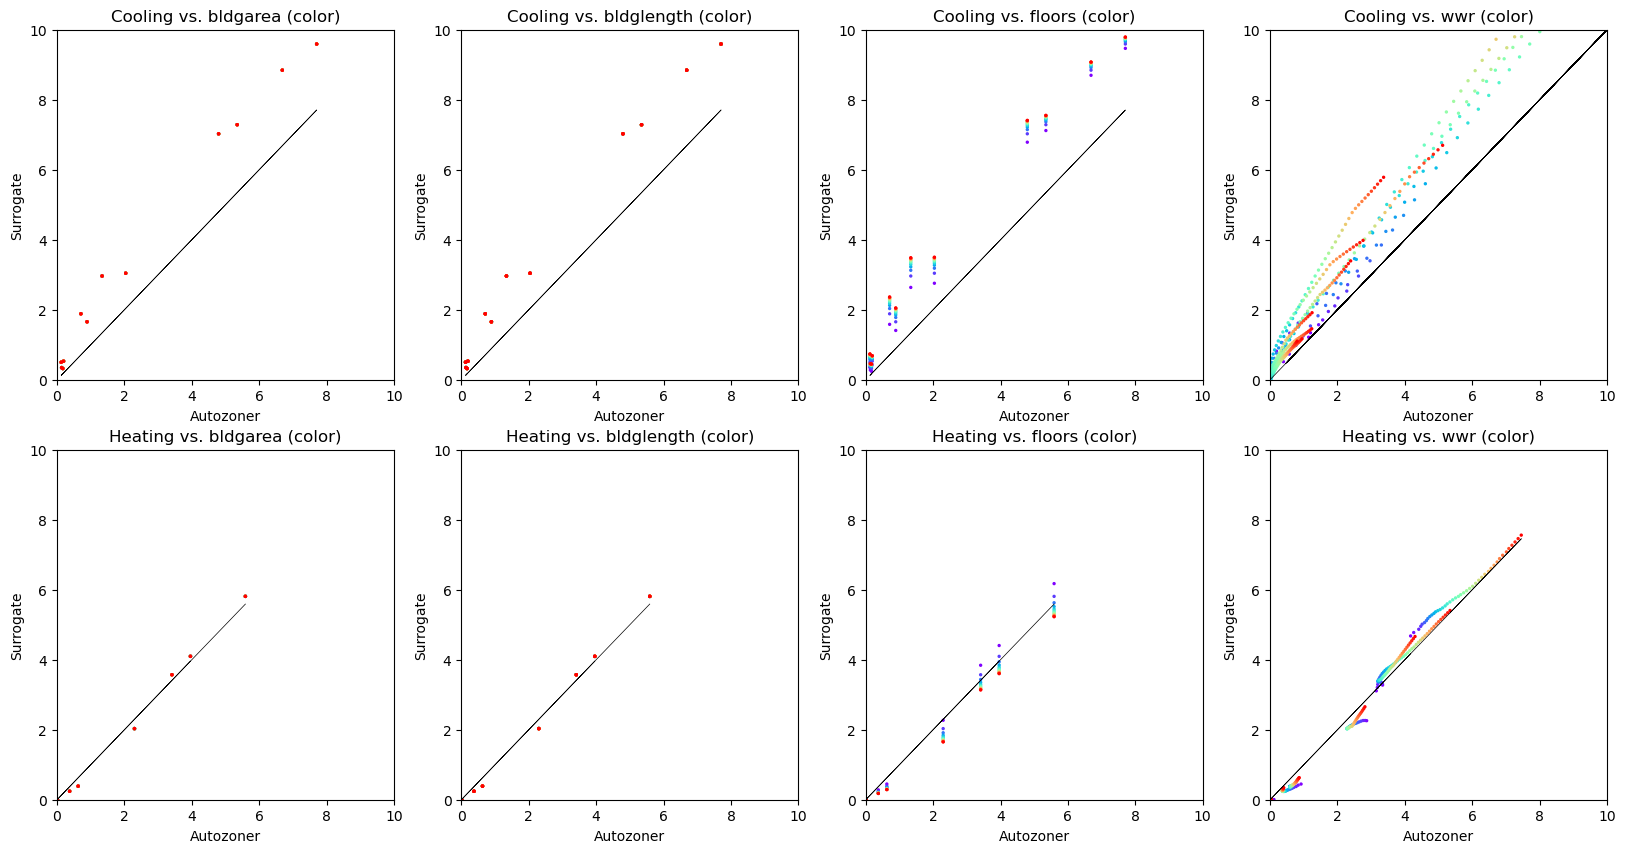

In [137]:
fig, axs = plt.subplots(2,4, figsize=(20,10))
def plot_compare(load, name, ax, **kwargs):
    ax.set_title(f"{load} vs. {name} (color)")
    results_df = pd.read_hdf(pth, key=name)
    a = results_df[load].loc["Autozoner"].stack().reset_index()
    b = results_df[load].loc["Surrogate"].stack().reset_index()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel("Autozoner")
    ax.set_ylabel("Surrogate")
    if "c" in kwargs:
        ax.scatter(a[0],b[0], s=2, **kwargs)
    else:
        ax.scatter(a[0],b[0],c=a["Val"].to_numpy(dtype=int), s=2, cmap="rainbow", **kwargs)
    ax.plot(a[0],a[0], "k-", lw=0.5)
    return plt

for i, load in enumerate(["Cooling", "Heating"]):
    for j, name in enumerate(['bldgarea', 'bldglength', 'floors', 'wwr']):
        plot_compare(load, name, axs[i][j])


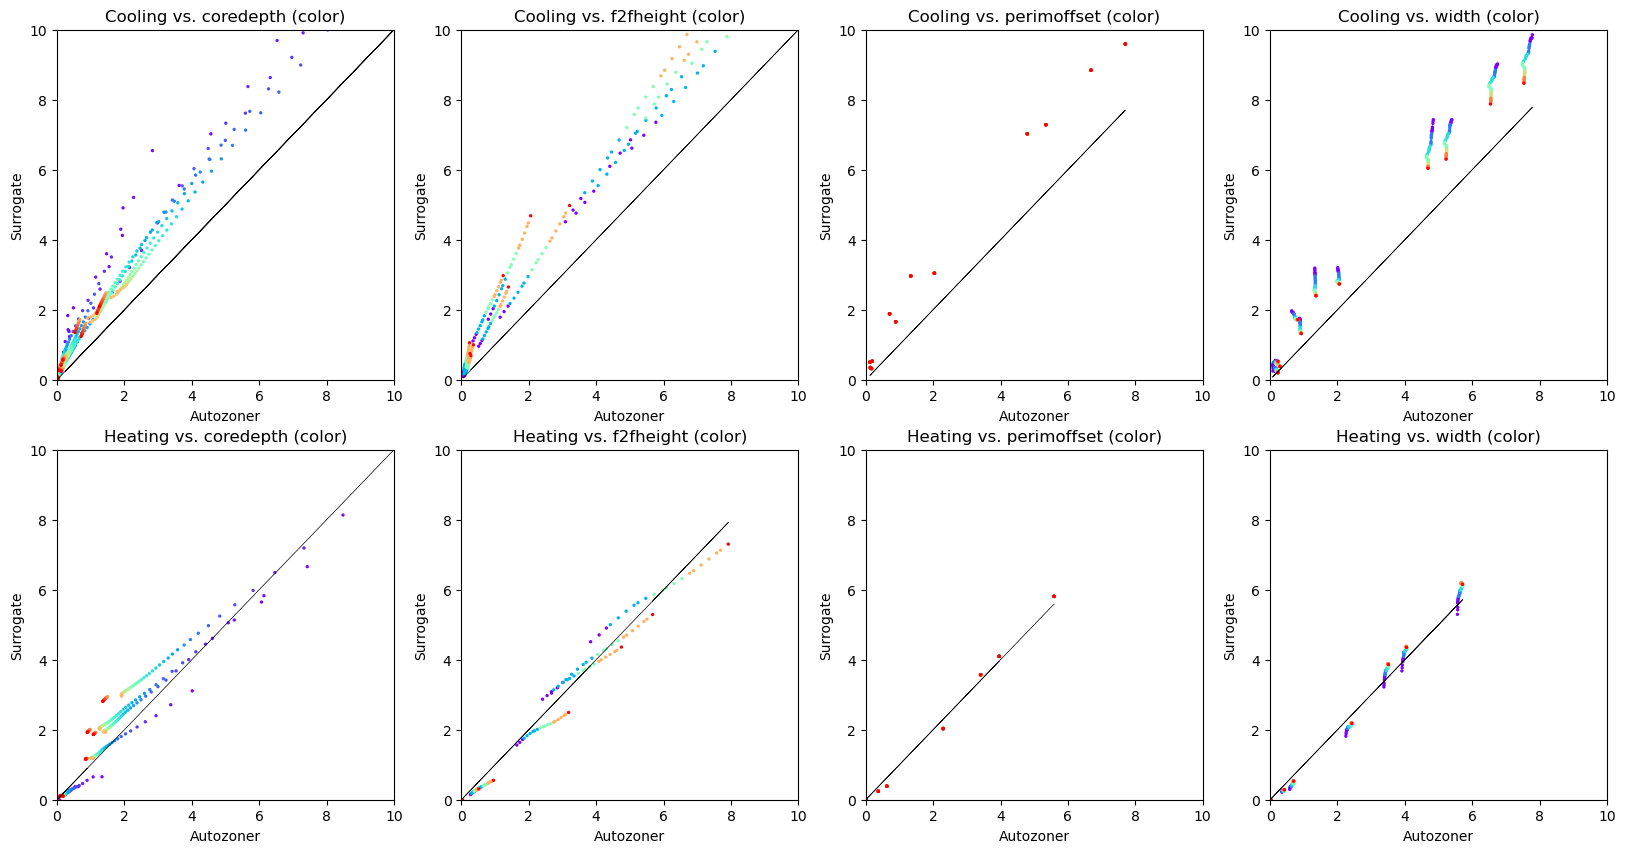

In [126]:
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i, load in enumerate(["Cooling", "Heating"]):
    for j, name in enumerate(['coredepth', 'f2fheight', 'perimoffset', 'width']):
        plot_compare(load, name, axs[i][j])

Attempt to fix cooling

In [21]:
all_results_df = pd.DataFrame(columns = results_df.columns, index=pd.MultiIndex(levels=[[],[]],codes=[[],[]], names=["Method", "Val"]))
for key in keys:
    df = pd.read_hdf(pth, key=key)
    all_results_df = pd.concat([all_results_df, df])

In [23]:
all_results_df.Cooling

,,0,1,2,3,4,5,6,7,8,9,10,11
Method,Val,,,,,,,,,,,,
CSshoeboxer,10.0,0.648764,0.873942,1.111358,4.869148,10.680114,22.507106,31.028167,26.547257,19.834893,5.097457,2.110874,0.509032
Autozoner,10.0,0.136531,0.193030,0.124070,0.708973,2.037859,5.346714,7.705311,6.686226,4.795442,1.337068,0.890746,0.171422
Whitebox,10.0,0.061042,0.101819,0.046971,0.708313,2.060168,5.716427,8.392217,7.266191,5.010051,1.178098,0.747851,0.086880
Surrogate,10.0,0.346008,0.528749,0.499855,1.883281,3.042751,7.286098,9.591466,8.844109,7.026375,2.963379,1.655014,0.320115
CSshoeboxer,12.0,0.576600,0.766492,0.853629,3.034398,6.664539,14.569388,20.239454,17.371208,12.785105,3.287130,1.545728,0.454598
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Surrogate,80.0,1.134048,1.417702,1.856748,3.918239,6.568622,13.210849,16.203849,14.730689,12.399969,5.686850,3.316957,1.064809
CSshoeboxer,82.0,1.435357,1.897510,2.120499,3.374930,5.664960,10.535712,14.044536,12.084275,9.202071,3.628395,2.436685,1.151475
Autozoner,82.0,0.949563,1.236832,1.246157,2.759795,5.121045,10.102648,13.521052,11.693863,9.000337,3.369687,2.391645,0.805655


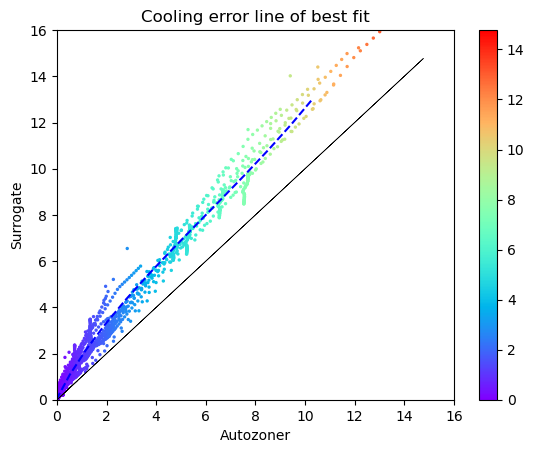

In [138]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


a = all_results_df.Cooling.loc["Autozoner"].stack().reset_index()
b = all_results_df.Cooling.loc["Surrogate"].stack().reset_index()
x_dat = a[0].to_numpy()
y_dat = b[0].to_numpy()

# define kernel of GP
rbf_lengthscale = 10 # lengthscale parameter
noise_assumption = 0.1 # noise assumption, a hyper-parameter

kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

rng = 13
x_grid = np.linspace(0, rng, rng).reshape(-1, 1)
model.fit(np.expand_dims(y_dat, axis=1), np.expand_dims(x_dat, axis=1))

# calculate mean and standard devation, make them one-dimensional for plotting
post_mean, post_std = model.predict(x_grid, return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

plt.title("Cooling error line of best fit")
lim = 16
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel("Autozoner")
plt.ylabel("Surrogate")
plt.scatter(a[0],b[0],c=a[0].to_numpy(), s=2, cmap="rainbow")
plt.plot(a[0],a[0], "k-", lw=0.5)
plt.plot(post_mean, x_grid.squeeze(), "b--", label = 'GP Posterior Mean')
# ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
plt.colorbar()

Replot with cooling scale

In [121]:
def plot_compare_gauss(load, name, ax):
    results_df = pd.read_hdf(pth, key=name)
    a = results_df[load].loc["Autozoner"].stack().reset_index()
    b = results_df[load].loc["Surrogate"].stack().reset_index()
    b = np.expand_dims(b[0].to_numpy(), axis=1)
    b_fixed = model.predict(b, return_std=False)
    ax.scatter(a[0],b_fixed,c=a["Val"].to_numpy(dtype=int), s=2, cmap="rainbow")
    ax.plot(a[0],a[0], "k-", lw=0.5)
    return plt

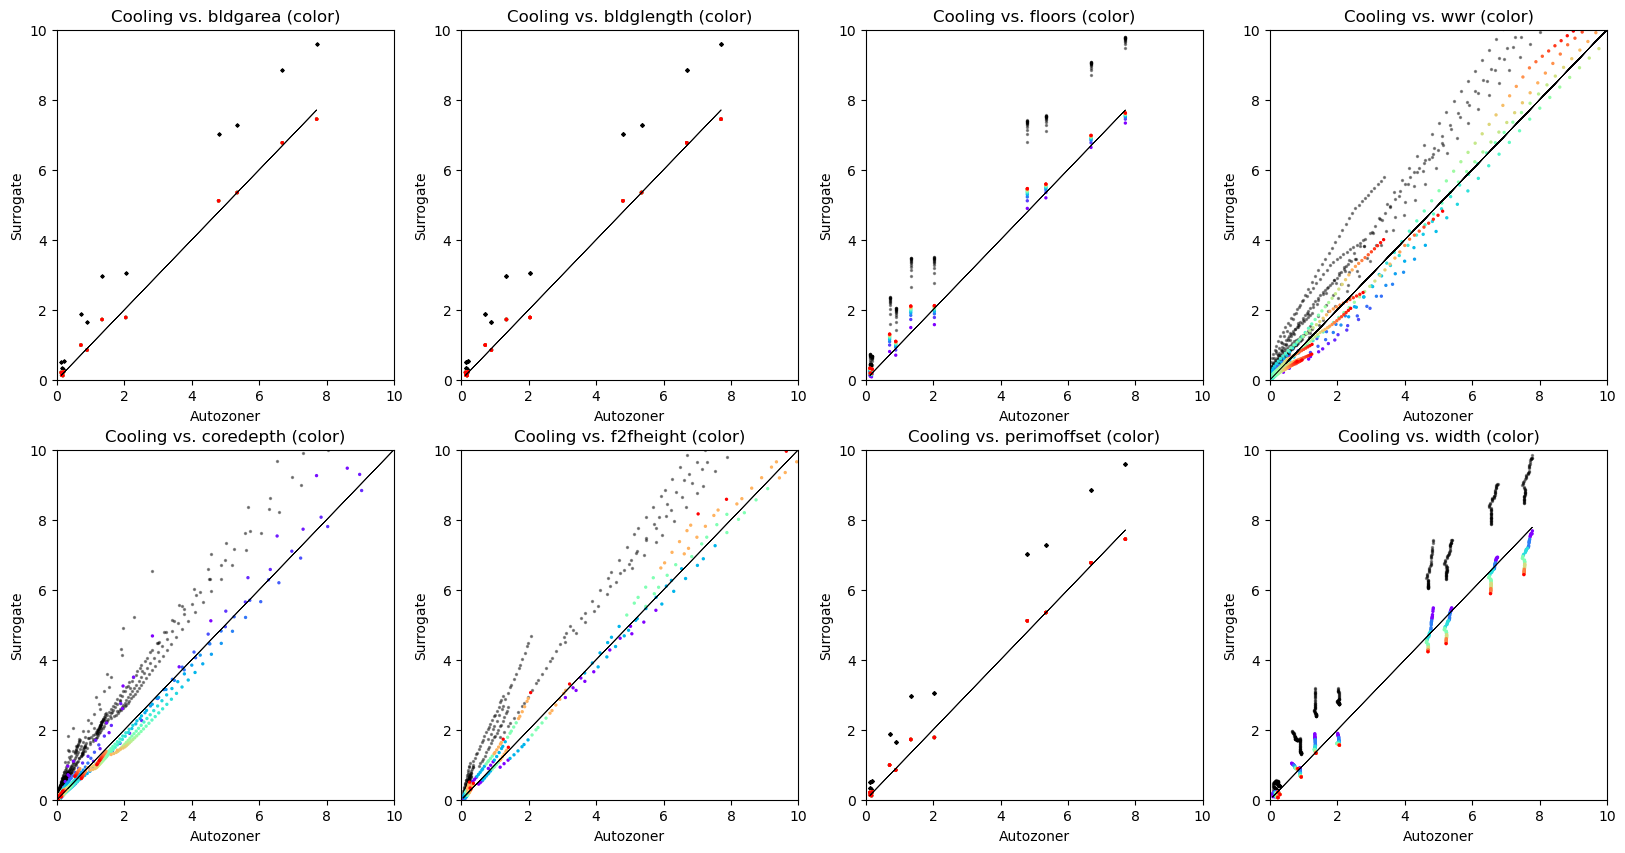

In [139]:
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i, load in enumerate(["Cooling"]):
    for j, name in enumerate(['bldgarea', 'bldglength', 'floors', 'wwr']):
        plot_compare(load, name, axs[i][j], alpha=0.4, c="k")
        plot_compare_gauss(load, name, axs[i][j])
for i, load in enumerate(["Cooling"]):
    for j, name in enumerate(['coredepth', 'f2fheight', 'perimoffset', 'width']):
        plot_compare(load, name, axs[i+1][j], alpha=0.4, c="k")
        plot_compare_gauss(load, name, axs[i+1][j])

In [150]:
results_df

Cooling                                                    \
                       0         1         2         3         4         5    
Method      Val                                                               
CSshoeboxer 2.0  0.405749  0.498064  0.499904  1.131470  2.446277  5.898409   
Autozoner   2.0  0.084204  0.141620  0.076468  0.640472  2.007785  5.392834   
Whitebox    2.0  0.043524  0.082266  0.031638  0.699033  2.079158  5.786710   
Surrogate   2.0  0.249056  0.501954  0.392789  1.968490  3.202879  7.427109   
CSshoeboxer 2.1  0.405749  0.498064  0.499904  1.131470  2.446277  5.898409   
...                   ...       ...       ...       ...       ...       ...   
Surrogate   7.9  0.198055  0.378887  0.526228  1.720163  2.736849  6.316702   
CSshoeboxer 8.0  0.405749  0.498064  0.499904  1.131470  2.446277  5.898409   
Autozoner   8.0  0.235192  0.293230  0.237124  0.825794  2.057938  5.224013   
Whitebox    8.0  0.081785  0.120116  0.069233  0.692164  1.961808  5.526106   
Surrogate   8.0  0.195971  0.378083  0.529210  1.721689  2.735197  6.300619   

                                                         ...   Heating  \
                       6         7         8         9   ...        2    
Method      Val                                          ...             
CSshoeboxer 2.0  8.409403  7.303923  5.286195  1.553879  ...  2.848062   
Autozoner   2.0  7.784169  6.750735  4.844919  1.327449  ...  2.249461   
Whitebox    2.0  8.485421  7.344968  5.069259  1.201463  ...  3.088573   
Surrogate   2.0  9.856068  9.020714  7.430970  3.189607  ...  1.814805   
CSshoeboxer 2.1  8.409403  7.303923  5.286195  1.553879  ...  2.848062   
...                   ...       ...       ...       ...  ...       ...   
Surrogate   7.9  8.484937  7.889693  6.047786  2.400644  ...  2.181885   
CSshoeboxer 8.0  8.409403  7.303923  5.286195  1.553879  ...  2.848062   
Autozoner   8.0  7.532787  6.541872  4.685821  1.362956  ...  2.428566   
Whitebox    8.0  8.124881  7.006571  4.834603  1.106132  ...  3.185502   
Surrogate   8.0  8.471844  7.876408  6.040671  2.400095  ...  2.180157   

                                                                             \
                       3         4         5         6         7         8    
Method      Val                                                               
CSshoeboxer 2.0  0.501801  0.004306  0.000000  0.000000  0.000000  0.000000   
Autozoner   2.0  0.355471  0.003264  0.000000  0.000000  0.000000  0.000000   
Whitebox    2.0  0.539377  0.013520  0.000000  0.000000  0.000000  0.000000   
Surrogate   2.0  0.220001 -0.011397 -0.012722 -0.016912 -0.015755 -0.014867   
CSshoeboxer 2.1  0.501801  0.004306  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
Surrogate   7.9  0.288004 -0.012401 -0.010203 -0.010896 -0.011732 -0.012738   
CSshoeboxer 8.0  0.501801  0.004306  0.000000  0.000000  0.000000  0.000000   
Autozoner   8.0  0.425537  0.008821  0.000000  0.000000  0.000000  0.000000   
Whitebox    8.0  0.588240  0.018417  0.000000  0.000000  0.000000  0.000000   
Surrogate   8.0  0.287919 -0.012480 -0.010112 -0.010731 -0.011600 -0.012814   

                                               
                       9         10        11  
Method      Val                                
CSshoeboxer 2.0  0.015530  0.568406  4.534489  
Autozoner   2.0  0.007148  0.582422  3.912100  
Whitebox    2.0  0.068271  1.032538  5.196753  
Surrogate   2.0 -0.011397  0.296677  3.679433  
CSshoeboxer 2.1  0.015530  0.568406  4.534489  
...                   ...       ...       ...  
Surrogate   7.9 -0.004672  0.531918  4.354399  
CSshoeboxer 8.0  0.015530  0.568406  4.534489  
Autozoner   8.0  0.030493  0.699831  4.049094  
Whitebox    8.0  0.092480  1.082678  5.206719  
Surrogate   8.0 -0.004743  0.531071  4.351652  

[204 rows x 24 columns]

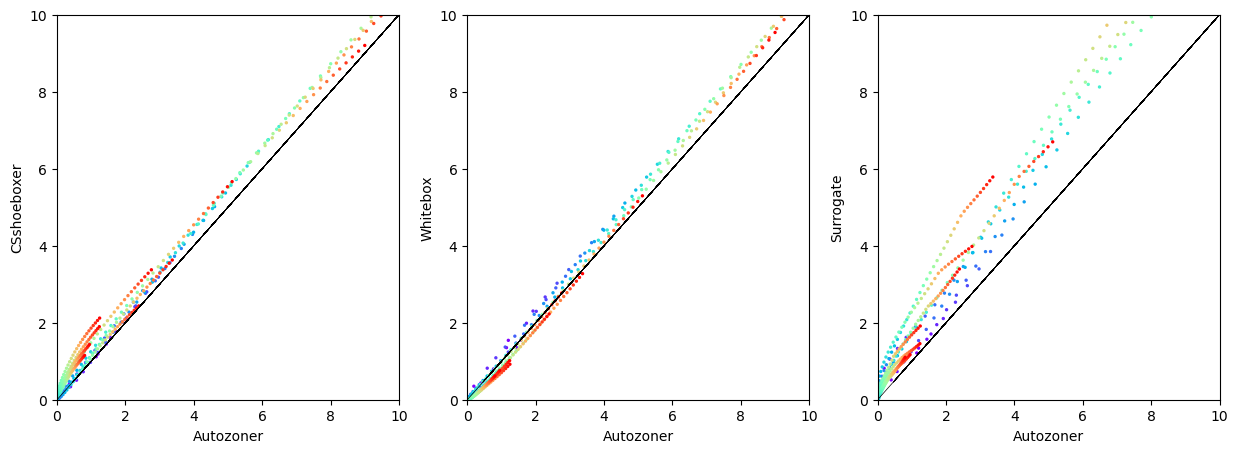

In [155]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
results_df = pd.read_hdf(pth, key="wwr")
lim = 10
for i, t in enumerate(["CSshoeboxer", "Whitebox", "Surrogate"]):
    a = results_df.Cooling.loc["Autozoner"].stack().reset_index()
    b = results_df.Cooling.loc[t].stack().reset_index()
    ax[i].set_xlim(0, lim)
    ax[i].set_ylim(0, lim)
    ax[i].set_xlabel("Autozoner")
    ax[i].set_ylabel(t)
    ax[i].scatter(a[0],b[0],c=a["Val"].to_numpy(), s=2, cmap="rainbow")
    ax[i].plot(a[0],a[0], "k-", lw=0.5)
    # ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
# ax[2].colorbar()

Get best width:

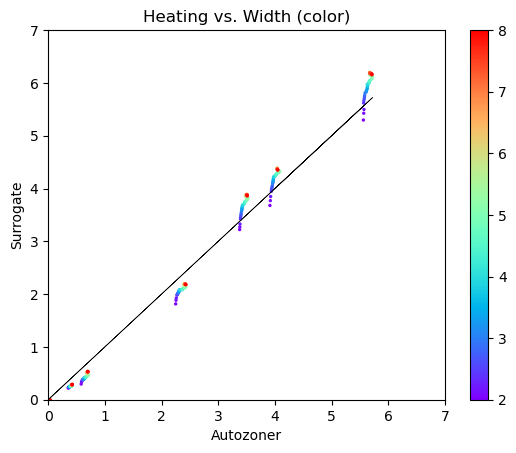

In [145]:
plt.title("Heating vs. Width (color)")

a = results_df.Heating.loc["Autozoner"].stack().reset_index()
b = results_df.Heating.loc["Surrogate"].stack().reset_index()

lim = 7
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel("Autozoner")
plt.ylabel("Surrogate")
plt.scatter(a[0],b[0],c=a["Val"].to_numpy(), s=2, cmap="rainbow")
plt.plot(a[0],a[0], "k-", lw=0.5)
# ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
plt.colorbar()

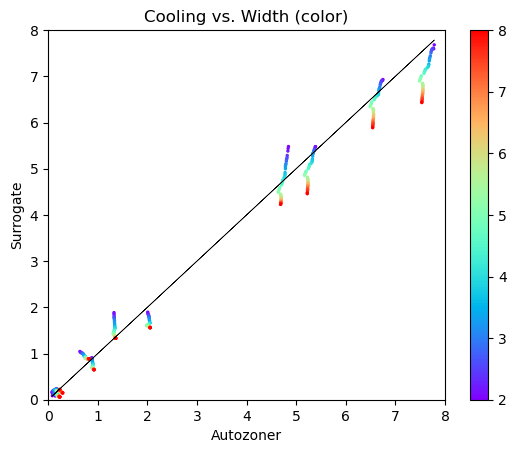

In [149]:
plt.title("Cooling vs. Width (color)")

a = results_df.Cooling.loc["Autozoner"].stack().reset_index()
b = results_df.Cooling.loc["Surrogate"].stack().reset_index()
b = np.expand_dims(b[0].to_numpy(), axis=1)
b_fixed = model.predict(b, return_std=False)

lim = 8
plt.xlim(0, lim)
plt.ylim(0, lim)
plt.xlabel("Autozoner")
plt.ylabel("Surrogate")
plt.scatter(a[0], b_fixed,c=a["Val"].to_numpy(), s=2, cmap="rainbow")
plt.plot(a[0],a[0], "k-", lw=0.5)
# ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
plt.colorbar()

In [156]:
len(os.listdir("data/epws/global_epws_indexed/"))

881

## Old

<Axes: title={'center': 'Cooling, Surrogate'}>

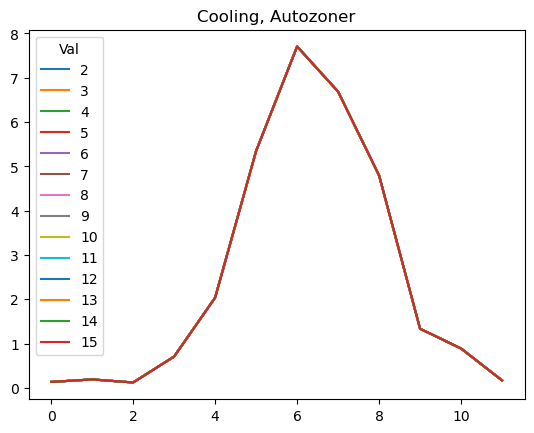

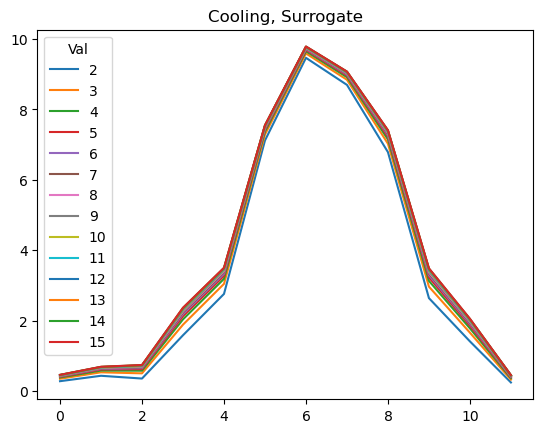

In [71]:
sweep.results_df.Cooling.loc["Autozoner"].T.plot(title="Cooling, Autozoner")
sweep.results_df.Cooling.loc["Surrogate"].T.plot(title="Cooling, Surrogate")

NameError: name 'shoebox_results' is not defined

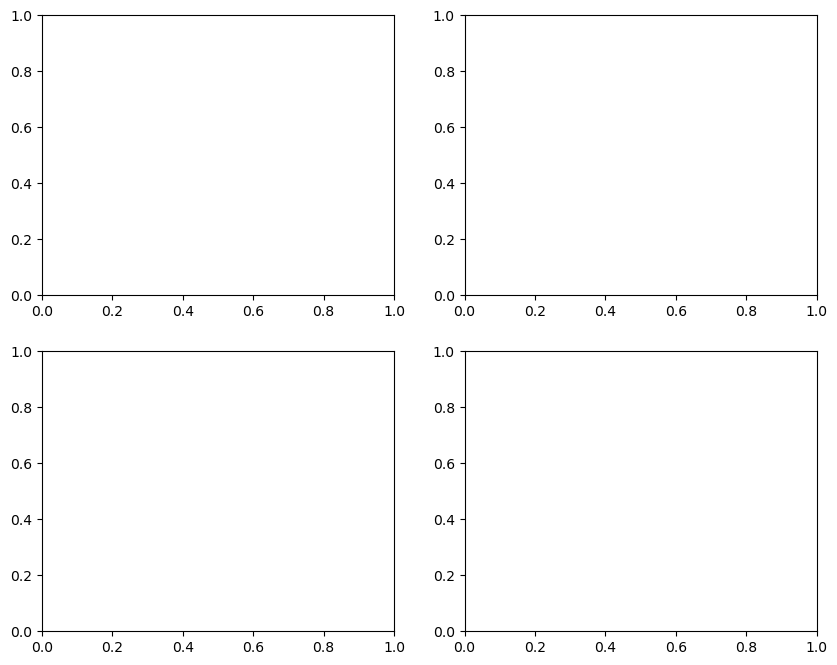

In [8]:
# shoebox_results = shoebox_results.set_index("box_name")
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
x = sorted(sweep.sweep_vals)
colors = {
    "bottom_south":"green",
    "middle_south": "green",
    "top_south": "green",
    "bottom_east":"blue",
    "middle_east": "blue",
    "top_east": "blue",
    "bottom_north":"yellow",
    "middle_north": "yellow",
    "top_north": "yellow",
    "bottom_west":"purple",
    "middle_west": "purple",
    "top_west": "purple",
}
fig,axs = plt.subplots(2,2,figsize=(10,8))
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]

for i in range(12):
    axs[0].plot(shoebox_results["Perimeter"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[1].plot(shoebox_results["Perimeter"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[2].plot(shoebox_results["Core"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[3].plot(shoebox_results["Core"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])


# axs[0].set_ylim([0,80])
# axs[1].set_ylim([0,5])
axs[0].yaxis.set_major_locator(MultipleLocator(5))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
axs[3].yaxis.set_major_locator(MultipleLocator(1))

axs[0].grid(axis="y",which="major")
axs[1].grid(axis="y",which="major")
axs[2].grid(axis="y",which="major")
axs[3].grid(axis="y",which="major")

axs[0].set_title("Perim Cooling")
axs[1].set_title("Perim Heating")
axs[2].set_title("Core Cooling")
axs[3].set_title("Core Heating")
plt.legend()
fig.tight_layout()

fig = plt.figure()
plt.plot(shoebox_results["Perimeter"]["Cooling"].mean(axis=0).values,"-o",color="blue",label="Perimeter Cooling Mean")
plt.plot(shoebox_results["Perimeter"]["Heating"].mean(axis=0).values,"-o",color="red",label="Perimeter Heating Mean")
plt.plot(shoebox_results["Core"]["Cooling"].mean(axis=0).values,"-o",color="lightblue",label="Core Cooling Mean",)
plt.plot(shoebox_results["Core"]["Heating"].mean(axis=0).values,"-o",color="pink",label="Core Heating Mean",)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.legend()
plt.grid(axis="y",which="major")

### Get CS results

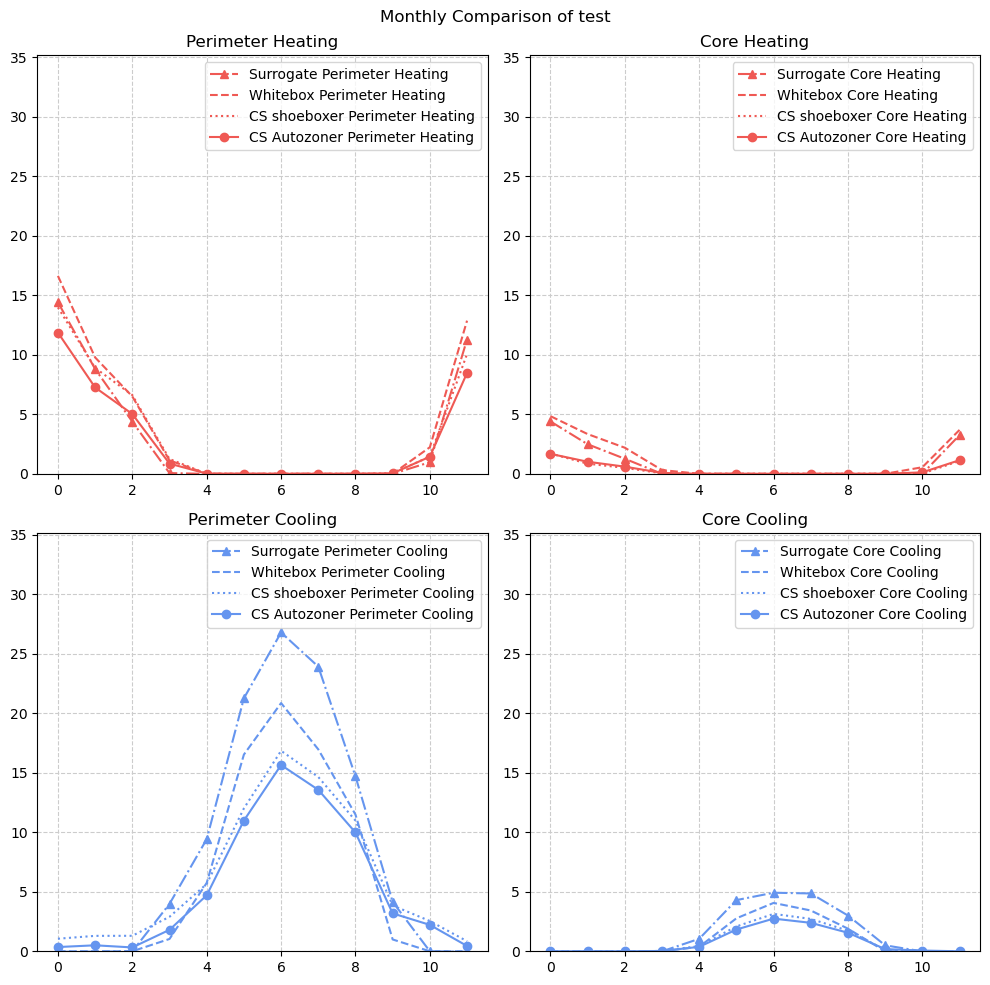

In [ ]:
ix = -1
fig, axs = plt.subplots(2,2, figsize=(10,10))

for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        axs[row,col].set_title(f"{zone} {end_use}")
        axs[row,col].plot(shoebox_results[zone][end_use].values[ix], "^-.", label=f"Surrogate {zone} {end_use}", color=color)
        axs[row,col].plot(wb_shoebox_results[zone][end_use].values[ix], "--", label=f"Whitebox {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results.CSshoeboxer[end_use][zone], ":", label=f"CS shoeboxer {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results.Autozoner[end_use][zone], "o-", label=f"CS Autozoner {zone} {end_use}", color=color)
        # legend
        axs[row,col].legend()
fig.tight_layout()

absolute_max = max(axs[0, 0].get_ylim()[1], axs[1, 0].get_ylim()[1])
grid_size = 5
while absolute_max / grid_size > 20:
    grid_size += 5 
for i in range(2):
    axs[0, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[0, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[1, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[1, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[0, i].set_ylim([0,1.25*absolute_max])
    axs[1, i].set_ylim([0,1.25*absolute_max])
plt.legend()
plt.suptitle(f"Monthly Comparison of {name}")
fig.tight_layout()